In [22]:
pip install opencv-python numpy matplotlib


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [24]:
# load images
query_img_color = cv2.imread('image1.jpeg')
train_img_color = cv2.imread('image2.jpeg')

# check if images loaded successfully
if query_img_color is None or train_img_color is None:
    print("Error: Could not load images")
    exit()

# convert to grayscale
query_img = cv2.cvtColor(query_img_color, cv2.COLOR_BGR2GRAY)
train_img = cv2.cvtColor(train_img_color, cv2.COLOR_BGR2GRAY)

# display image dimensions
print(f"Query image shape: {query_img.shape}")
print(f"Train image shape: {train_img.shape}")


Query image shape: (2048, 1536)
Train image shape: (2048, 1536)


In [25]:
orb = cv2.ORB_create(
    nfeatures=2000,           # max features to retain
    scaleFactor=1.2,          # pyramid scale factor
    nlevels=8,                # number of pyramid levels
    edgeThreshold=31,         # border size where features aren't detected
    firstLevel=0,             # pyramid level to start from
    WTA_K=2,                  # number of points for BRIEF descriptor
    scoreType=cv2.ORB_HARRIS_SCORE,  # HARRIS_SCORE
    patchSize=31,             # size of patch used for descriptor
    fastThreshold=20          # FAST detector threshold
)


In [26]:
# detect keypoints and compute descriptors for both images
kp_query, des_query = orb.detectAndCompute(query_img, None)
kp_train, des_train = orb.detectAndCompute(train_img, None)

# print statistics
print(f"Query image: {len(kp_query)} keypoints detected")
print(f"Train image: {len(kp_train)} keypoints detected")

# examine a keypoint structure
if kp_query:
    kp = kp_query[0]
    print(f"\nKeypoint attributes:")
    print(f"  Position: ({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")
    print(f"  Size: {kp.size}")
    print(f"  Angle: {kp.angle}°")
    print(f"  Response: {kp.response}")

# check descriptor properties
print(f"\nDescriptor properties:")
print(f"  Shape: {des_query.shape}")
print(f"  Data type: {des_query.dtype}")
print(f"  Each descriptor: 32 bytes (256 bits)")


Query image: 2000 keypoints detected
Train image: 2000 keypoints detected

Keypoint attributes:
  Position: (1085.00, 1640.00)
  Size: 31.0
  Angle: 226.72262573242188°
  Response: 0.001958003267645836

Descriptor properties:
  Shape: (2000, 32)
  Data type: uint8
  Each descriptor: 32 bytes (256 bits)


In [27]:
# Brute-Force Matcher with cross-check
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Brute-Force Matcher without cross-check (More Matches, Noisier)
# bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# FLANN-based Matcher (Faster for Large Datasets)
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2)
search_params = dict(checks=50)
# flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)


In [28]:
# simple matching with cross-check
matches = bf_matcher.match(des_query, des_train)

# If not using cross-check, apply sorting
# matches = sorted(matches, key=lambda x: x.distance)

# print match statistics
print(f"Total matches found: {len(matches)}")
if matches:
    distances = [m.distance for m in matches]
    print(f"  Best match distance: {min(distances)}")
    print(f"  Worst match distance: {max(distances)}")
    print(f"  Average distance: {np.mean(distances):.2f}")
    print(f"  Std deviation: {np.std(distances):.2f}")

# inspect first few matches
print("\nFirst 5 matches:")
for i, match in enumerate(matches[:5]):
    print(f"  Match {i}: query_idx={match.queryIdx}, train_idx={match.trainIdx}, distance={match.distance}")


Total matches found: 642
  Best match distance: 20.0
  Worst match distance: 77.0
  Average distance: 44.43
  Std deviation: 10.30

First 5 matches:
  Match 0: query_idx=1, train_idx=595, distance=35.0
  Match 1: query_idx=3, train_idx=828, distance=51.0
  Match 2: query_idx=5, train_idx=476, distance=34.0
  Match 3: query_idx=8, train_idx=857, distance=44.0
  Match 4: query_idx=9, train_idx=545, distance=36.0


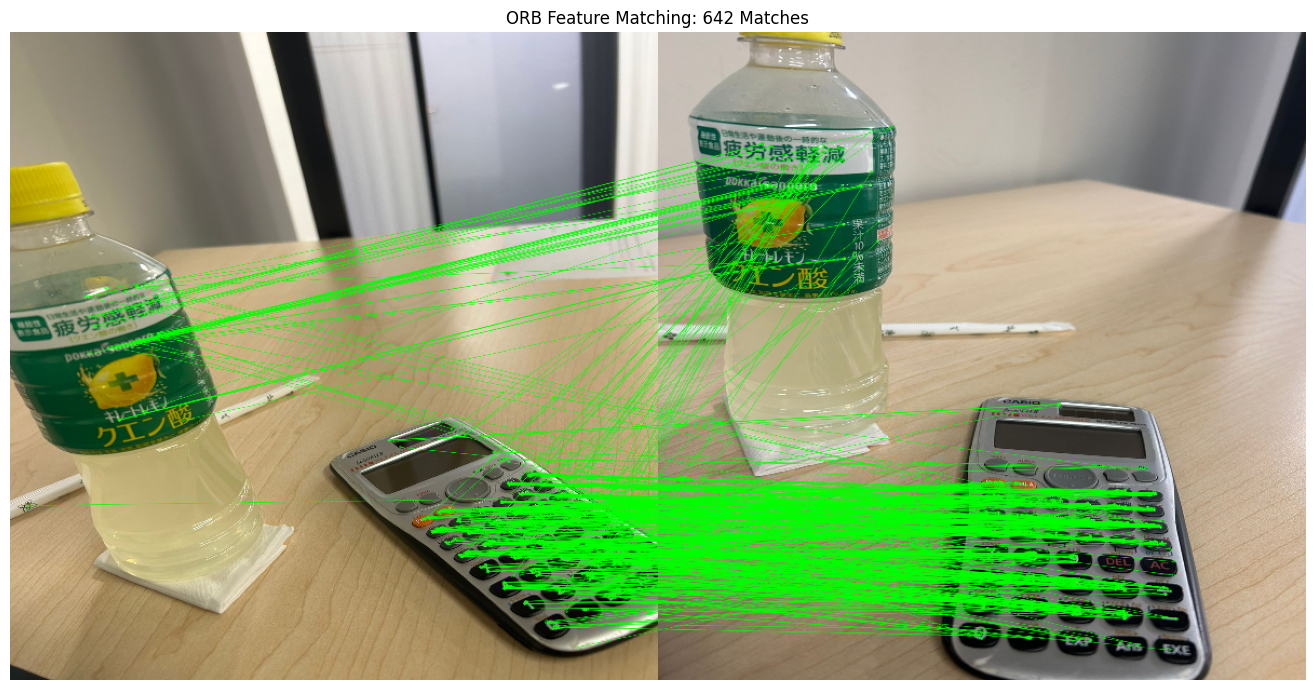

In [29]:
# draw top N matches
num_matches_to_draw = min(1000, len(matches))
result_img = cv2.drawMatches(
    query_img_color,              # First image (color)
    kp_query,                     # Keypoints from first image
    train_img_color,              # Second image (color)
    kp_train,                     # Keypoints from second image
    matches[:num_matches_to_draw],  # Matches to draw
    None,                         # Output array (None = create new)
    matchColor=(0, 255, 0),       # Green for matches
    singlePointColor=(255, 0, 0), # Red for unmatched points
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# resize for better visibility if needed
result_img = cv2.resize(result_img, (1200, 600))

# display using Matplotlib
plt.figure(figsize=(14, 7))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f'ORB Feature Matching: {num_matches_to_draw} Matches')
plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
# sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# keep only good matches
good_matches = []
for match in matches:
    if match.distance < 50:  # threshold for ORB
        good_matches.append(match)

# alternative: keep top 10% of matches
# good_matches = matches[:int(len(matches) * 0.1)]
print(f"Found {len(good_matches)} good matches")


Found 447 good matches


Source points shape: (447, 1, 2)
Destination points shape: (447, 1, 2)
Homography matrix:
[[ 5.87544669e-01 -7.34262152e-01  1.26325889e+03]
 [ 2.03866907e-01  8.17516828e-01 -1.93865227e+02]
 [-2.17959884e-04  6.59706875e-05  1.00000000e+00]]
Inlier count: 179 / 447
Inlier matches after RANSAC: 179


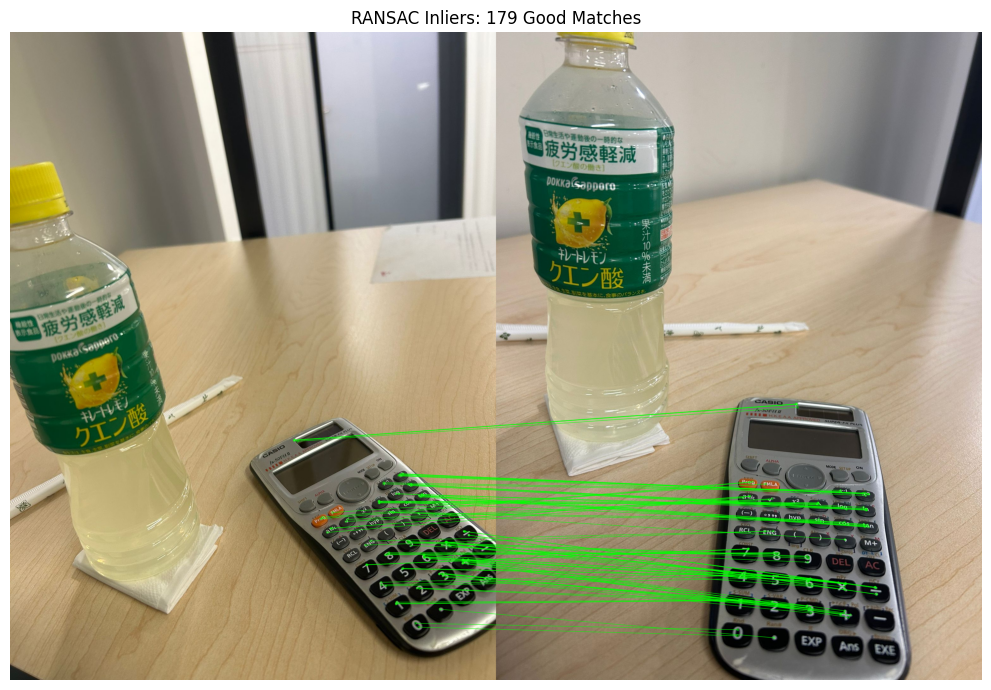

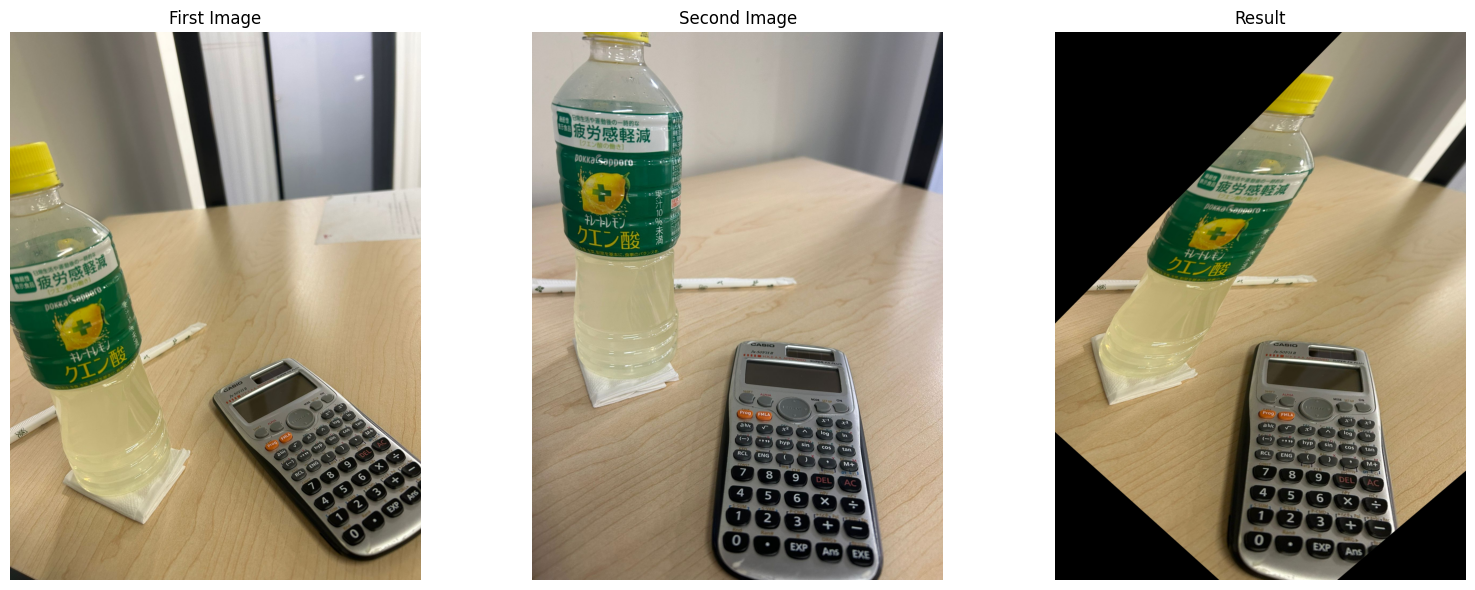

In [31]:
# extract corresponding Keypoint Coordinates
# extract coordinates of good matches
src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

print(f"Source points shape: {src_pts.shape}")
print(f"Destination points shape: {dst_pts.shape}")

# calculate Homography matrix
if len(good_matches) >= 4:  # Need at least 4 points for homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    print(f"Homography matrix:\n{H}")
    print(f"Inlier count: {np.sum(mask)} / {len(good_matches)}")
else:
    print("Not enough good matches for homography (need >=4)")
    H = None

# visualize inliers only (RANSAC filtered matches)
inlier_matches = [m for i, m in enumerate(good_matches) if mask[i]]
print(f"Inlier matches after RANSAC: {len(inlier_matches)}")

inlier_img = cv2.drawMatches(
    query_img_color, kp_query, train_img_color, kp_train,
    inlier_matches[:100], None,  # limit to 100 for visualization
    matchColor=(0, 255, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(14, 7))
plt.imshow(cv2.cvtColor(inlier_img, cv2.COLOR_BGR2RGB))
plt.title(f'RANSAC Inliers: {len(inlier_matches)} Good Matches')
plt.axis('off')
plt.tight_layout()
plt.show()

# warp query image to train image perspective
if H is not None:
    h, w = train_img.shape
    query_warped = cv2.warpPerspective(query_img_color, H, (w, h))

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(query_img_color, cv2.COLOR_BGR2RGB))
    plt.title('First Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(train_img_color, cv2.COLOR_BGR2RGB))
    plt.title('Second Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(query_warped, cv2.COLOR_BGR2RGB))
    plt.title('Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Cannot warp: No valid homography")
